# TACHE 7 : el_bands

Dans ce notebook, nous allons déterminer la bande interdite du cristal SrCN₂, trouver la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion, et, calculer la masse effective au sommet (base) de la dernière (première) bande de valence (conduction) en supposant une dispersion parabolique.

In [55]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.electronic_structure import bandstructure
from pymatgen.electronic_structure import plotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


In [56]:
mp_key = "hGFJONMWFhZMzX55ulNNTvmOkGE07nJS"
mp_id = "mp-12317"

In [57]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Bande interdite

La bande interdite du SrCN₂ est dite indirecte. En effet, nous pouvons remarquer sur le graphe que le haut de la bande de valence ne correspond pas au bas de la bande de conduction.


In [58]:
gap = el_bs.get_band_gap()
e_band = gap.get('energy')
print('Informations de la bande interdite : ')
print('Energie de la bande interdite :', e_band, 'eV.')
print('La bande interdite est-elle direct ? :',gap.get('direct'))
print('La bande interdite se situe entre 0 eV et {} eV.'.format(e_band))
print("Vecteur de transition :", gap['transition'])

Informations de la bande interdite : 
Energie de la bande interdite : 3.2055999999999996 eV.
La bande interdite est-elle direct ? : False
La bande interdite se situe entre 0 eV et 3.2055999999999996 eV.
Vecteur de transition : Z-\Gamma


In [59]:
fig_el_bs = get_plot_bs(el_bs, plot_range=[-5,9])
xvals = fig_el_bs.to_dict()["data"][0]["x"]
yvals_vbm = fig_el_bs.to_dict()["data"][2]["y"]
yvals_cbm = fig_el_bs.to_dict()["data"][3]["y"]
xvals_band_edges = []
yvals_band_edges = []
for i in el_bs.get_vbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_vbm[i])
for i in el_bs.get_cbm()["kpoint_index"]:
    xvals_band_edges.append(xvals[i])
    yvals_band_edges.append(yvals_cbm[i])
for i in el_bs.get_vbm()["kpoint_index"]:
    scatter = go.Scatter(
        x = xvals_band_edges, y = yvals_band_edges,
        mode = "markers", marker = dict(color="black"),
        showlegend=False)
    fig_el_bs.add_trace(scatter)
fig_el_bs.update_layout(xaxis_range = [xvals[0], xvals[-1]])
fig_el_bs.show()

## Dispersion

Dans cette section nous allons trouver la direction dans laquelle la dernière bande de valence présente le plus et le moins de dispersion ainsi que la direction dans laquelle la première bande de conduction présente le plus et le moins de dispersion.
Pour cela, nous allons calculer la pente de l'énergie en fonction du vecteur d'onde k pour chaque segment de la structure de bandes. En effet, une pente élevée signifie une forte variation d'énergie avec k indiquant une grande dispersion. A l'inverse, une pente faible indique une faible variation d'énergie avec k, indiquant une petite dispersion.<br>
Ensuite, nous déterminons la direction de ces grandes et petites dispersions grâce au graphique.

La dispersion maximale de la dernière bande de valence se situe entre les abscisses [2.496488194843472, 3.1172502123107213]
 et entre les ordonnées [0.0, -0.9744999999999999]
La dispersion minimal de la dernière bande de valence se situe entre les abscisses [4.217137757821406, 4.685158179257835]
 et entre les ordonnées [-0.5267, -0.6997]
La dispersion maximale de la première bande de conduction se situe entre les abscisses [0.928580344007059, 1.5604476155501747]
 et entre les ordonnées [4.116099999999999, 5.4306]
La dispersion minimal de la première bande de conduction se situe entre les abscisses [4.685158179257835, 4.912676908826386]
 et entre les ordonnées [4.471299999999999, 4.4895]


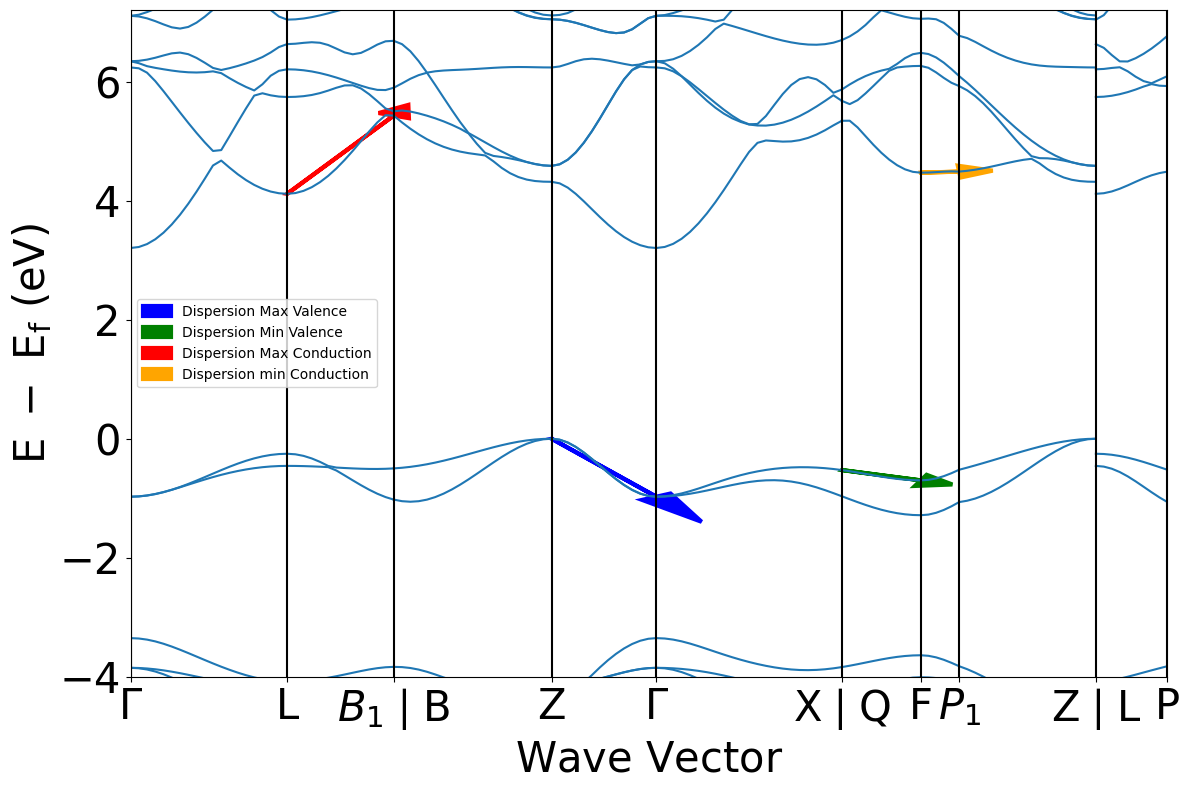

In [60]:
data = plotter.BSPlotter(el_bs).bs_plot_data()

# Initialisation des variables pour suivre les pentes maximales et minimales
v_xi = 0
v_bandsi = 0
v_xf = 0
v_bandsf = 0

v_pente_max = 0
v_pente_min = 100

v_x_max = [0, 0]
v_bands_max = [0, 0]
v_x_min = [0, 0]
v_bands_min = [0, 0]

# On itère sur les indices des bandes
i_vbm = list(el_bs.get_vbm()['band_index'].values())[-1][-1]

for i in range(len(data["distances"])): 
    v_x = data["distances"][i]  # Récupération de la distance k
    v_y = data["energy"]['1'][i]  # Récupération des énergies des bandes

    # Extraction des points de départ et de fin
    v_xi = v_x[0]  # Premier point k
    v_xf = v_x[-1]  # Dernier point k

    v_bandsi = v_y[i_vbm][0]  # Énergie initiale
    v_bandsf = v_y[i_vbm][-1]  # Énergie finale
    # Calcul de la pente
    v_pente = np.abs((v_bandsf - v_bandsi) / (v_xf - v_xi))  

    # Mise à jour des valeurs maximales et minimales
    if v_pente >= v_pente_max:
        v_pente_max = v_pente
        v_x_max = [v_xi, v_xf]
        v_bands_max = [v_bandsi, v_bandsf]

    if v_pente <= v_pente_min:
        v_pente_min = v_pente
        v_x_min = [v_xi, v_xf]
        v_bands_min = [v_bandsi, v_bandsf]

# Initialisation des variables pour suivre les pentes maximales et minimales
c_xi = 0
c_bandsi = 0
c_xf = 0
c_bandsf = 0

c_x_max = [0, 0]
c_bands_max = [0, 0]
c_x_min = [0, 0]
c_bands_min = [0, 0]

c_pente_max = 0
c_pente_min = 100

# On itère sur les indices des bandes
i_cbm = list(el_bs.get_cbm()['band_index'].values())[-1][0]

for i in range(len(data["distances"])): 
    c_x = data["distances"][i]  # Récupération de la distance k
    c_y = data["energy"]['1'][i]  # Récupération des énergies des bandes

    # Extraction des points de départ et de fin
    c_xi = c_x[0]  # Premier point k
    c_xf = c_x[-1]  # Dernier point k

    c_bandsi = c_y[i_cbm][0]  # Énergie initiale
    c_bandsf = c_y[i_cbm][-1]  # Énergie finale
    # Calcul de la pente
    c_pente = np.abs((c_bandsf - c_bandsi) / (c_xf - c_xi))  

    # Mise à jour des valeurs maximales et minimales
    if c_pente >= c_pente_max:
        c_pente_max = c_pente
        c_x_max = [c_xi, c_xf]
        c_bands_max = [c_bandsi, c_bandsf]

    if c_pente <= c_pente_min:
        c_pente_min = c_pente
        c_x_min = [c_xi, c_xf]
        c_bands_min = [c_bandsi, c_bandsf]

print('La dispersion maximale de la dernière bande de valence se situe entre les abscisses ' + str(v_x_max) + 
      '\n et entre les ordonnées ' + str(v_bands_max))
print('La dispersion minimal de la dernière bande de valence se situe entre les abscisses ' + str(v_x_min) + 
      '\n et entre les ordonnées ' + str(v_bands_min))
print('La dispersion maximale de la première bande de conduction se situe entre les abscisses ' + str(c_x_max) + 
      '\n et entre les ordonnées ' + str(c_bands_max))
print('La dispersion minimal de la première bande de conduction se situe entre les abscisses ' + str(c_x_min) + 
      '\n et entre les ordonnées ' + str(c_bands_min))
# Obtention de la figure existante
BSPlotter(el_bs).get_plot()

# Flèches pour la bande de valence (bleu)
plt.arrow(v_x_max[0], v_bands_max[0], v_x_max[1] - v_x_max[0], v_bands_max[1] - v_bands_max[0],
         head_width=0.2, head_length=0.5,linewidth=3, fc='blue', ec='blue', label="Dispersion Max Valence")

plt.arrow(v_x_min[0], v_bands_min[0], v_x_min[1] - v_x_min[0], v_bands_min[1] - v_bands_min[0],
         head_width=0.2, head_length=0.2, linewidth=3, fc='green', ec='green', label="Dispersion Min Valence")

# Flèches pour la bande de conduction (rouge)
plt.arrow(c_x_max[0], c_bands_max[0], c_x_max[1] - c_x_max[0], c_bands_max[1] - c_bands_max[0],
         head_width=0.2, head_length=0.2, linewidth=3, fc='red', ec='red', label="Dispersion Max Conduction")

plt.arrow(c_x_min[0], c_bands_min[0], c_x_min[1] - c_x_min[0], c_bands_min[1] - c_bands_min[0],
         head_width=0.2, head_length=0.2,linewidth=3, fc='orange', ec='orange', label="Dispersion min Conduction")

plt.legend()
plt.show()

En analysans le graphique, nous remarquons: <br>
La plus faible dispersion de la dernière bande de valence est dans la direction X|Q-F et la direction de la plus grande dispersion est Z-$\Gamma$.<br>
La plus faible dispersion de la première bande de conduction est dans la direction F-P1 et la direction de la plus grande dispersion est L-B1|B.<br>

## Masse effective

Les électrons sont souvent décrits comme des particules libres dont la masse effective varie. Cette masse effective peut-être
positive ou négative, supérieure ou inférieure à la masse réelle de l'électron.<br>
En supposant une dispersion parabolique, la masse effective est définie par : $$m^* = \frac{\hbar^2 k^2}{2 \cdot E(k)} = \frac{\hbar^2 (k_x^2 + k_y^2 + k_z^2)}{2 \cdot E(k)}$$


In [61]:
kpoint_v = el_bs.get_vbm().get('kpoint').frac_coords
kpoint_c = el_bs.get_cbm().get('kpoint').frac_coords
norme_v = np.linalg.norm(kpoint_v)
norme_c = np.linalg.norm(kpoint_c)
print('Pour la bande de valence, la valeur de la norme du vecteur d onde est {:.4f}'.format(norme_v), '[1/Å]')
print('Pour la bande de conduction, la valeur de la norme du vecteur d onde est est {:.4f}'.format(norme_c), '[1/Å]')

Pour la bande de valence, la valeur de la norme du vecteur d onde est 0.8660 [1/Å]
Pour la bande de conduction, la valeur de la norme du vecteur d onde est est 0.0000 [1/Å]


La norme de la bande de conduction est nulle. Dans ce cas, nous allons profiter de la périodicté du réseau réciproque tel que $E_{n, k} = E_{n, k+p}$ avec $p = C \frac{2\pi}{a}$ où a est la norme du vecteur de base du réseau direct et C une constante.

In [62]:
reseau_direct = prim_struc.lattice
a = reseau_direct.a
p = 1*(2*np.pi)/a
print('Finalement, la valeur de la norme du vecteur d onde, pour la bande de conduction, est {:.4f}'.format(p), '[1/Å]')

Finalement, la valeur de la norme du vecteur d onde, pour la bande de conduction, est 1.1351 [1/Å]


In [64]:
h_bar = 6.5822e-16
cbm = el_bs.get_cbm()
E_cbm = cbm['energy']
vbm = el_bs.get_vbm()
E_vbm = vbm['energy']
m_e = 9.109e-31
m_v = ((h_bar*1.602e-19)**2 * (kpoint_v[0]**2+kpoint_v[1]**2+kpoint_v[2]**2)*(1e10)**2)/(2*abs(E_vbm)*1.602e-19)
print('Au sommet de la dernière bande de valence :')
print('   ℏ = {:.4e} eV*s.'.format(h_bar))
print('   E(k) = {:.4f} eV.'.format(E_vbm))
print('   k² = (k_x² + k_y² + k_z²) = |k|² = {:.4f} [1/Å].'.format((kpoint_v[0]**2+kpoint_v[1]**2+kpoint_v[2]**2)) )
print('   Sachant que 1eV = 1.602×10^−19 J et 1Å = 10^-10 m:')
print('   La masse effective au sommet de la dernière bande de valence: m* = {:.4e} kg.'.format(m_v))
print('')
m_c = ((h_bar*1.602e-19)**2 * (p**2)*(1e10)**2)/(2*E_cbm*1.602e-19)
print('A la base de la première bande de conduction :')
print('   ℏ = {:.4e} eV*s.'.format(h_bar))
print('   E(k) = {:.4f} eV.'.format(E_cbm))
print('   k² = (2𝜋/a)² = {:.4f} [1/Å].'.format(p**2) )
print('   Sachant que 1eV = 1.602×10^−19 J et 1Å = 10^-10 m:')
print('   La masse effective à la base de la première bande de conduction: m* = {:.4e} kg.'.format(m_c))
print('')
print('Masse de l électron libre: m = {:.4e} kg.'.format(m_e))
print('Rapports de masse :')
print('Au sommet de la dernière bande de valence: m*/m = {:.4f}.'.format(m_v/m_e))
print('A la base de la première bande de conduction : m*/m = {:.4f}.'.format(m_c/m_e))

Au sommet de la dernière bande de valence :
   ℏ = 6.5822e-16 eV*s.
   E(k) = 0.8311 eV.
   k² = (k_x² + k_y² + k_z²) = |k|² = 0.7500 [1/Å].
   Sachant que 1eV = 1.602×10^−19 J et 1Å = 10^-10 m:
   La masse effective au sommet de la dernière bande de valence: m* = 3.1317e-30 kg.

A la base de la première bande de conduction :
   ℏ = 6.5822e-16 eV*s.
   E(k) = 4.0367 eV.
   k² = (2𝜋/a)² = 1.2884 [1/Å].
   Sachant que 1eV = 1.602×10^−19 J et 1Å = 10^-10 m:
   La masse effective à la base de la première bande de conduction: m* = 1.1077e-30 kg.

Masse de l électron libre: m = 9.1090e-31 kg.
Rapports de masse :
Au sommet de la dernière bande de valence: m*/m = 3.4380.
A la base de la première bande de conduction : m*/m = 1.2160.


Nous remarquons que les deux rapports de masse sont très élevé (>1) ce qui signifie que l'énergie dans les bandes de conductions et de valence ne dépend que faiblement du vecteur d'onde k. En effet, si les fonctions d'ondes centrées sur les atomes voisins se recouvrent très peu, la largeur de bande sera très faible et la masse effective très grande.